<a href="https://colab.research.google.com/github/luanakwon/ML_Pytorch_pre2022/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tried to recreate CycleGAN paper.  
  
  I think I've exactly copied the architecture written in the paper but the result is not quite satisfying. Besides that I learned how to handle image in pytorch/pyplot. 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optimizer
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# dataset links
# https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/
# paper link
# https://arxiv.org/pdf/1703.10593.pdf
# summer2winter dataset
# 'drive/MyDrive/Dataset/summer2winter_yosemite/train_A'
# 'drive/MyDrive/Dataset/summer2winter_yosemite/train_B'
# 'drive/MyDrive/Dataset/summer2winter_yosemite/test_A'
# 'drive/MyDrive/Dataset/summer2winter_yosemite/test_B'
# horse2zebra dataset
# 'drive/MyDrive/Dataset/horse2zebra/train_A'
# 'drive/MyDrive/Dataset/horse2zebra/train_B'
# 'drive/MyDrive/Dataset/horse2zebra/test_A'
# 'drive/MyDrive/Dataset/horse2zebra/test_B'

In [ ]:
####### hyperparameters #####
current_epoch = 0
epoch = 200
lr = 0.0002
cycle_loss_coef = 10
n_res_blocks = 6
use_image_buffer = False
buffer_max = 50

batch_size = 8
image_size = 128
num_workers = 2

load_checkpoint = True
CHECKPOINT_SAVE_PATH = 'drive/MyDrive/NN_saves/checkpoints/'
CHECKPOINT_LOAD_PATH = 'drive/MyDrive/NN_saves/checkpoints/CycleGAN_CP_0525_1631.pth'

In [ ]:
datasetA = dsets.ImageFolder(root='drive/MyDrive/Dataset/horse2zebra/train_A',
                            transform=transforms.Compose([               
                            transforms.Resize((image_size,image_size)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))                           
                          ]))
datasetB = dsets.ImageFolder(root='drive/MyDrive/Dataset/horse2zebra/train_B',
                            transform=transforms.Compose([               
                            transforms.Resize((image_size,image_size)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))                           
                          ]))

print(datasetA)
print(datasetB)

dataloaderA = DataLoader(datasetA,batch_size, 
                         shuffle=True,num_workers=num_workers, drop_last=True)
dataloaderB = DataLoader(datasetB,batch_size, 
                         shuffle=True,num_workers=num_workers, drop_last=True)

#print(next(dataloaderB)[0].shape)

Dataset ImageFolder
    Number of datapoints: 1067
    Root location: drive/MyDrive/Dataset/horse2zebra/train_A
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 1334
    Root location: drive/MyDrive/Dataset/horse2zebra/train_B
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [ ]:
def init_weight(m):
  if type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d:
    init.normal_(m.weight.data,std=0.02)

In [ ]:
# image Buffer class using queue data structure
# push by batch(B,C,H,W)
# get returns buffer (type: np array)


class ImageBuffer():
  def __init__(self, buffer_capacity, batch_shape):
    # buffer capacity has to be n*batch_size
    self.capacity = buffer_capacity
    self.buffer = np.zeros(batch_shape)
    self.index = 0
    self.n_batch = batch_shape[0]
  
  def push(self, x):
    if self.index == 0:
      self.buffer += x
      self.index += self.n_batch
    elif self.index < self.capacity:
      self.buffer = np.concatenate((self.buffer, x),axis=0)
      self.index += self.n_batch
    else:
      s_idx = self.index%self.capacity
      self.buffer[s_idx:s_idx+self.n_batch] = x[:]
      self.index += self.n_batch

  def get(self):
    return self.buffer
  
  def show(self):
    print(self.buffer)

  def __len__(self):
    return self.buffer.shape[0]


# test = ImageBuffer(4,(2,3,4,4))
# im = np.ones((2,3,4,4))
# im2 = np.zeros((2,3,4,4))
# for i in range(3):
#   test.push(im)
# test.push(im2)
# test.show()
# print(test.get_buffer().shape)


In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels, kernel, stride, bias):
    super(ResidualBlock, self).__init__()

    self.conv_layer = nn.Sequential(
        nn.Conv2d(channels, channels, kernel, 
                  stride, padding=(kernel-1)//2,padding_mode='reflect', bias=bias),
        nn.InstanceNorm2d(channels),
        nn.ReLU(True),
        nn.Conv2d(channels, channels, kernel, 
                  stride, padding=(kernel-1)//2,padding_mode='reflect', bias=bias),
        nn.InstanceNorm2d(channels)
    )
    self.activation = nn.ReLU(True)

  def forward(self, x):
    # print("it's me resblock")
    y = self.conv_layer(x)
    y = self.activation(x+y)
    return y
    # return x+y

In [ ]:
class Generator(nn.Module):
  def __init__(self, n_res_blocks, use_bias):
    super(Generator, self).__init__()

    self.n_res_blocks = n_res_blocks

    self.first_layer = nn.Sequential(
        # 3, image_size, image_size
        nn.Conv2d(in_channels=3, out_channels=64, 
                  kernel_size=7, stride=1, padding=3,padding_mode='reflect',bias=use_bias),
        nn.InstanceNorm2d(64),
        nn.ReLU(True)
        # 64, i, i
    )
    self.downsample_layer = nn.Sequential(
        # 64, i, i
        nn.Conv2d(64,128,3,2,1,padding_mode='reflect',bias=use_bias),
        nn.InstanceNorm2d(128),
        nn.ReLU(True),
        # 128, i/2, i/2
        nn.Conv2d(128,256,3,2,1,padding_mode='reflect',bias=use_bias),
        nn.InstanceNorm2d(256),
        nn.ReLU(True)
        # 256, i/4, i/4
    )
    
    res = []
    for i in range(n_res_blocks):
      res.append(ResidualBlock(256,3,1,use_bias))
    self.resnet = nn.Sequential(*res)
    
    self.upsample_layer = nn.Sequential(
        # 256, i/4, i/4
        nn.ConvTranspose2d(256,128,3,2,1,
                           output_padding=1,bias=use_bias),
        nn.InstanceNorm2d(128),
        nn.ReLU(True),
        # 128, i/2, i/2
        nn.ConvTranspose2d(128,64,3,2,1,
                           output_padding=1,bias=use_bias),
        nn.InstanceNorm2d(64),
        nn.ReLU(True)
        # 64, i, i
    )
    self.last_layer = nn.Sequential(
        # 64, i, i
        nn.Conv2d(64,3,7,1,3,padding_mode='reflect',bias=use_bias),
        nn.Tanh()
        # 3, i, i
    )

  def forward(self, input_):
    gen_out = self.first_layer(input_)
    gen_out = self.downsample_layer(gen_out)
    gen_out = self.resnet(gen_out)
    gen_out = self.upsample_layer(gen_out)
    gen_out = self.last_layer(gen_out)
    
    return gen_out


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, image_size, use_bias):
    super(Discriminator, self).__init__()
    self.layer_cov = nn.Sequential(
        # 3, image_size, image_size
        nn.Conv2d(3,64,4,2,1,padding_mode='reflect',bias=use_bias),
        nn.LeakyReLU(0.2, True),
        # 64, i/2, i/2
        nn.Conv2d(64,128,4,2,1,padding_mode='reflect',bias=use_bias),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2, True),
        # 128, i/4, i/4
        nn.Conv2d(128,256,4,2,1,padding_mode='reflect',bias=use_bias),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2, True),
        # 256, i/8, i/8
        nn.Conv2d(256,512,4,1,1,padding_mode='reflect',bias=use_bias),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2, True),
        # 512, i/8 - 1, i/8 - 1
        nn.Conv2d(512,1,4,1,1,padding_mode='reflect',bias=use_bias),
        nn.Sigmoid()
        # 1, i/8 - 2, i/8 - 2
    )
  
  def forward(self, input_):
    out = self.layer_cov(input_)
    return out

In [ ]:
device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')
print(device)

generatorG = nn.DataParallel(Generator(n_res_blocks, True)).to(device)
generatorF = nn.DataParallel(Generator(n_res_blocks, True)).to(device)
discriminatorX = nn.DataParallel(Discriminator(image_size,True)).to(device)
discriminatorY = nn.DataParallel(Discriminator(image_size,True)).to(device)

generatorG.apply(init_weight)
generatorF.apply(init_weight)
discriminatorX.apply(init_weight)
discriminatorY.apply(init_weight)

print(generatorG,generatorF,discriminatorX,discriminatorY)

cuda
DataParallel(
  (module): Generator(
    (first_layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (downsample_layer): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
    (resnet): Sequential(
      (0): ResidualBlock(
        (conv_layer): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
         

In [ ]:
loss_L1 = nn.L1Loss()
loss_L2 = nn.MSELoss()

G_optim = optimizer.Adam(generatorG.parameters(),lr=lr, betas=(0.5,0.999))
F_optim = optimizer.Adam(generatorF.parameters(),lr=lr, betas=(0.5,0.999))
Dx_optim = optimizer.Adam(discriminatorX.parameters(),lr=lr,betas=(0.5,0.999))
Dy_optim = optimizer.Adam(discriminatorY.parameters(),lr=lr,betas=(0.5,0.999))

lr_lambda = lambda e : 1 if e<(epoch)//2 else -e/(epoch//2)+2
scheduler = []
scheduler.append(optimizer.lr_scheduler.LambdaLR(G_optim,lr_lambda))
scheduler.append(optimizer.lr_scheduler.LambdaLR(F_optim,lr_lambda))
scheduler.append(optimizer.lr_scheduler.LambdaLR(Dx_optim,lr_lambda))
scheduler.append(optimizer.lr_scheduler.LambdaLR(Dy_optim,lr_lambda))

# def ones_label(B):
#   return torch.ones(B,1,image_size//(2**3) - 2,image_size//(2**3) - 2).to(device)
# def zeros_label(B):
#   return torch.zeros(B,1,image_size//(2**3) - 2,image_size//(2**3) - 2).to(device)

In [ ]:
def save_checkpoint(current_epoch, PATH):
  torch.save({
      'current_epoch':current_epoch,
      'generatorG':generatorG.state_dict(),
      'generatorF':generatorF.state_dict(),
      'discriminatorX':discriminatorX.state_dict(),
      'discriminatorY':discriminatorY.state_dict(),
      'G_optim':G_optim.state_dict(),
      'F_optim':F_optim.state_dict(),
      'Dx_optim':Dx_optim.state_dict(),
      'Dy_optim':Dy_optim.state_dict(),
      'scheduler1':scheduler[0].state_dict(),
      'scheduler2':scheduler[1].state_dict(),
      'scheduler3':scheduler[2].state_dict(),
      'scheduler4':scheduler[3].state_dict()
  }, PATH)

In [ ]:
if load_checkpoint:
  checkpoint = torch.load(CHECKPOINT_LOAD_PATH)
  current_epoch = checkpoint['current_epoch']
  generatorG.load_state_dict(checkpoint['generatorG'])
  generatorF.load_state_dict(checkpoint['generatorF'])
  discriminatorX.load_state_dict(checkpoint['discriminatorX'])
  discriminatorY.load_state_dict(checkpoint['discriminatorY'])
  G_optim.load_state_dict(checkpoint['G_optim'])
  F_optim.load_state_dict(checkpoint['F_optim'])
  Dx_optim.load_state_dict(checkpoint['Dx_optim'])
  Dy_optim.load_state_dict(checkpoint['Dy_optim'])
  scheduler[0].load_state_dict(checkpoint['scheduler1'])
  scheduler[1].load_state_dict(checkpoint['scheduler2'])
  scheduler[2].load_state_dict(checkpoint['scheduler3'])
  scheduler[3].load_state_dict(checkpoint['scheduler4'])

  # checkpoint = torch.load('drive/MyDrive/NN_saves/checkpoints/CycleGAN_CP_0520_1655.pth')
  # discriminatorY.load_state_dict(checkpoint['discriminatorY'])

In [ ]:
G_Loss = []
F_Loss = []
C_Loss = []
Dx_Loss = []
Dy_Loss = []

for e in range(current_epoch,epoch):
  dataAIterator = iter(dataloaderA)
  dataBIterator = iter(dataloaderB)
  finishedIteration = 0
  i = 0
  if use_image_buffer:
    G_fake_buffer = ImageBuffer(buffer_max,(batch_size,3,image_size,image_size))
    F_fake_buffer = ImageBuffer(buffer_max,(batch_size,3,image_size,image_size))
    imageA_buffer = ImageBuffer(buffer_max,(batch_size,3,image_size,image_size))
    imageB_buffer = ImageBuffer(buffer_max,(batch_size,3,image_size,image_size))


  while finishedIteration < 2:
    # bring each batch from dataloader
    try:
      imageA = next(dataAIterator)[0].to(device)
    except StopIteration:
      dataAIterator = iter(dataloaderA)
      imageA = next(dataAIterator)[0].to(device)
      finishedIteration += 1
    
    try:
      imageB = next(dataBIterator)[0].to(device)
    except StopIteration:
      dataBIterator = iter(dataloaderB)
      imageB = next(dataBIterator)[0].to(device)
      finishedIteration += 1

    G_fake = generatorG.forward(imageA)
    F_restore = generatorF.forward(G_fake)
    F_fake = generatorF.forward(imageB)
    G_restore = generatorG.forward(F_fake)
    Dx_fake = discriminatorX.forward(F_fake)
    Dy_fake = discriminatorY.forward(G_fake)

    # cycle consistency loss
    c_loss = loss_L1(F_restore, imageA) + loss_L1(G_restore, imageB)
    # generator G loss
    G_loss = loss_L2(Dy_fake, torch.ones_like(Dy_fake))
    # generator F loss
    F_loss = loss_L2(Dx_fake, torch.ones_like(Dx_fake))
    # total generator loss
    gen_loss = G_loss + F_loss + c_loss * cycle_loss_coef

    # generator learning
    G_optim.zero_grad()
    F_optim.zero_grad()
    gen_loss.backward()
    G_optim.step()
    F_optim.step()

    
    G_fake = generatorG.forward(imageA)
    F_fake = generatorF.forward(imageB)

    # buffer push new Images
    if use_image_buffer:
      G_fake_buffer.push(G_fake.cpu().detach().numpy())
      F_fake_buffer.push(F_fake.cpu().detach().numpy())
      imageA_buffer.push(imageA.cpu().detach().numpy())
      imageB_buffer.push(imageB.cpu().detach().numpy())

      imageA = torch.Tensor(imageA_buffer.get()).to(device)
      imageB = torch.Tensor(imageB_buffer.get()).to(device)
      G_fake = torch.Tensor(G_fake_buffer.get()).to(device)
      F_fake = torch.Tensor(F_fake_buffer.get()).to(device)
    else:
      F_fake = F_fake.detach()
      G_fake = G_fake.detach()


    Dx_real = discriminatorX.forward(imageA)
    Dx_fake = discriminatorX.forward(F_fake)
    Dy_real = discriminatorY.forward(imageB)
    Dy_fake = discriminatorY.forward(G_fake)
    
    # discriminatorX loss
    Dx_loss = (loss_L2(Dx_fake,torch.zeros_like(Dx_fake)) + loss_L2(Dx_real, torch.ones_like(Dx_real))) / 2
    # discriminatorY loss
    Dy_loss = (loss_L2(Dy_fake,torch.zeros_like(Dy_fake)) + loss_L2(Dy_real, torch.ones_like(Dy_real))) / 2

    # Dx learning
    Dx_optim.zero_grad()
    Dx_loss.backward()
    Dx_optim.step()
    # Dy learning
    Dy_optim.zero_grad()
    Dy_loss.backward()
    Dy_optim.step()

    # for s in scheduler:
    #   s.step()

    G_Loss.append(G_loss.data)
    F_Loss.append(F_loss.data)
    C_Loss.append(c_loss.data)
    Dx_Loss.append(Dx_loss.data)
    Dy_Loss.append(Dy_loss.data)

    i += 1
    if i%20==0:
      print('\rEpoch: %d, batch: %d G_loss: %f, D_loss: %f, C_loss: %f'%(
        e,i, G_loss.data+F_loss.data, Dx_loss.data + Dy_loss.data, c_loss.data), end='')
      
  
  if e%15==0:
    tm = time.localtime()
    save_checkpoint(e+1,CHECKPOINT_SAVE_PATH+'CycleGAN_CP_%02d%02d_%02d%02d.pth'%(
        tm.tm_mon,tm.tm_mday,tm.tm_hour,tm.tm_min))
      
print('\n',len(imageA_buffer))
  

Epoch: 170, batch: 100 G_loss: 1.621782, D_loss: 0.150300, C_loss: 0.165555

KeyboardInterrupt: ignored

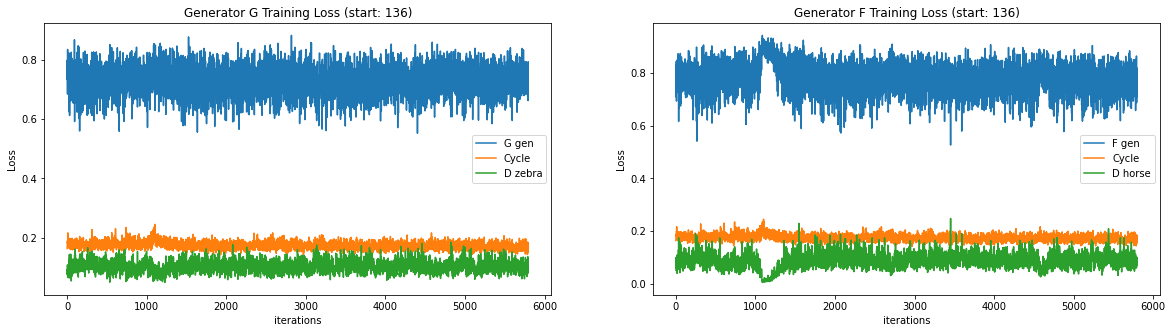

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Generator G Training Loss (start: %d)"%(current_epoch))
plt.plot(G_Loss,label="G gen")
plt.plot(C_Loss,label="Cycle")
plt.plot(Dy_Loss,label="D zebra")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.title("Generator F Training Loss (start: %d)"%(current_epoch))
plt.plot(F_Loss,label="F gen")
plt.plot(C_Loss,label="Cycle")
plt.plot(Dx_Loss,label="D horse")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
imageA_buffer = ImageBuffer(buffer_max,(batch_size,3,image_size,image_size))
imageB_buffer = ImageBuffer(buffer_max,(batch_size,3,image_size,image_size))

for image, l in dataloaderA:
  imageA_buffer.push(image.numpy())
  if len(imageA_buffer) >= 8:
    break

for image, l in dataloaderB:
  imageB_buffer.push(image.numpy())
  if len(imageB_buffer) >= 8:
    break

print(imageA_buffer.get().shape)

(8, 3, 128, 128)


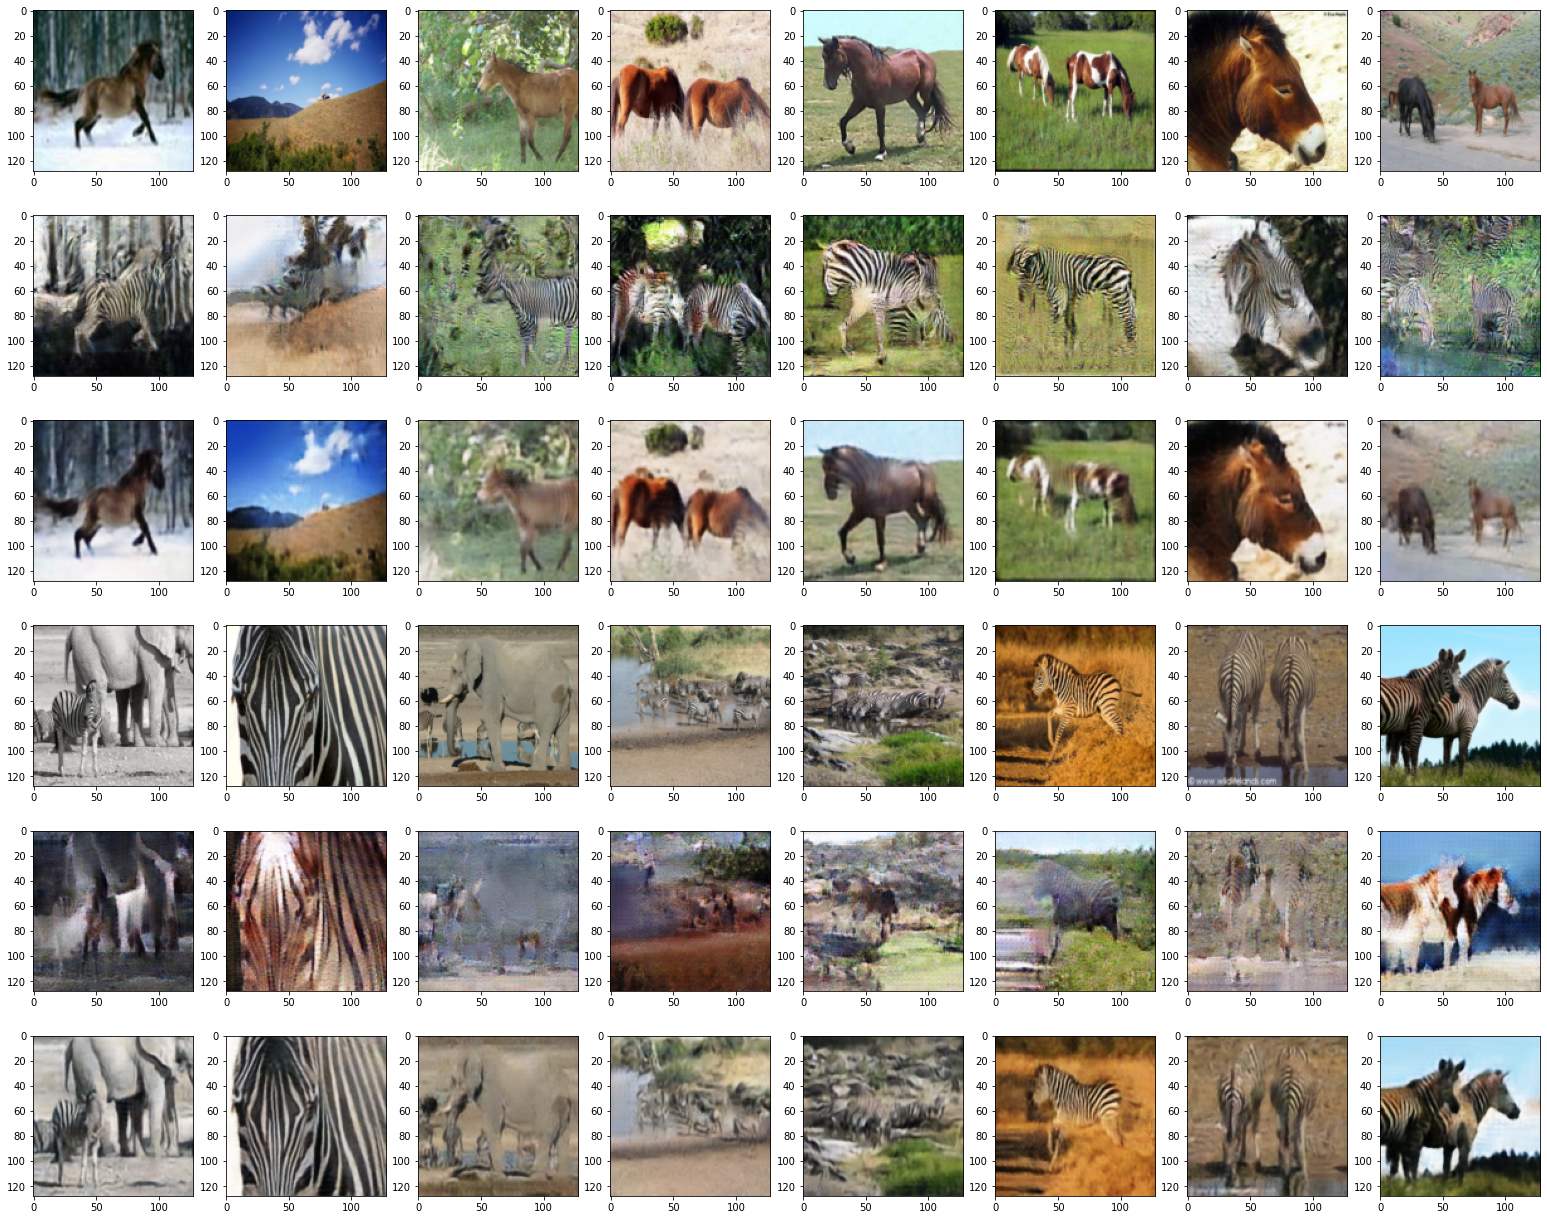

In [ ]:
with torch.no_grad():
  imageA = torch.Tensor(imageA_buffer.get()).to(device)
  imageB = torch.Tensor(imageB_buffer.get()).to(device)
  
  A1 = generatorG.forward(imageA)*0.5 + 0.5
  A2 = generatorF.forward(A1)*0.5 + 0.5
  B1 = generatorF.forward(imageB)*0.5 + 0.5
  B2 = generatorG.forward(B1)*0.5 + 0.5

  imageA = np.transpose(imageA.cpu().detach().numpy()*0.5+0.5, (0,2,3,1))
  A1 = np.transpose(A1.cpu().detach().numpy(), (0,2,3,1)).clip(0,1)
  A2 = np.transpose(A2.cpu().detach().numpy(), (0,2,3,1)).clip(0,1)
  imageB = np.transpose(imageB.cpu().detach().numpy()*0.5+0.5, (0,2,3,1)).clip(0,1)
  B1 = np.transpose(B1.cpu().detach().numpy(), (0,2,3,1)).clip(0,1)
  B2 = np.transpose(B2.cpu().detach().numpy(), (0,2,3,1)).clip(0,1)
  

  imagelist = []
  for a in imageA[:8]:
    imagelist.append(a)
  for a in A1[:8]:
    imagelist.append(a)
  for a in A2[:8]:
    imagelist.append(a)
  for a in imageB[:8]:
    imagelist.append(a)
  for a in B1[:8]:
    imagelist.append(a)
  for a in B2[:8]:
    imagelist.append(a)

  
  plt.figure(figsize=(27,22))
  for i in range(48):
    plt.subplot(6,8,i+1)
    plt.imshow(imagelist[i])

  
  plt.show()
  

In [ ]:
save_path = './drive/MyDrive/NN_saves/'
ver = '_0525.pth'
torch.save(generatorG.state_dict(),save_path + 'CycleGAN_G'+ver)
torch.save(discriminatorX.state_dict(),save_path + 'CycleGAN_Dx'+ver)
torch.save(generatorF.state_dict(),save_path + 'CycleGAN_F'+ver)
torch.save(discriminatorY.state_dict(),save_path + 'CycleGAN_Dy'+ver)